Analysing inside higher education capital campaign data

http://www.insidehighered.com/capital_campaigns#

In [1]:
%matplotlib inline

from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns
import random 
import warnings
import operator
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

path = "./"

from pandas import ExcelWriter
from pandas import ExcelFile
 
df = pd.read_excel('higherEd.xlsx', sheetname='Capital Campaign')
 
print("Column headings:")
print(df.columns)

Column headings:
Index(['College', 'Year Started', 'End Date', 'Top priorities', 'Goal',
       'Raised to Date'],
      dtype='object')


In [2]:
def replace(s, r1, r2):
    s = str(s).replace(r1,r2)
    return s

df['End Date'] = df.apply(lambda r: replace(r['End Date'], "No end date", '2020'), axis=1)
df['Ended'] = df['End Date'].str.contains('Ended', regex=False)
#df['Ended'] = df.apply(lambda r: replace(r['Ended'], "nan", 'False'), axis=1)
df['End Date'] = df.apply(lambda r: replace(r['End Date'], "Ended", ''), axis=1)
#df = df.replace('',np.NaN)
df['Goal (USD millions)'] = (df['Goal'].astype(float)/1000000).astype(str)
df['Raised (USD millions)'] = (df['Raised to Date'].astype(float)/1000000).astype(str)
df = df.drop(['Goal', 'Raised to Date'], axis=1)
df = df.astype({"College": str, "End Date": int,"Top priorities": str, "Goal (USD millions)": float, "Raised (USD millions)": float, "Ended": bool})
df.info()
df['Years'] = df['End Date'].sub(df['Year Started'], axis = 0)
df['Expected'] = df['Raised (USD millions)'].sub(df['Goal (USD millions)'], axis = 0)
df['Raised (USD millions)'] = df['Raised (USD millions)'].fillna(17.0)
df['Expected'] = df['Expected'].fillna(0)
df.head(n=30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 7 columns):
College                  82 non-null object
Year Started             82 non-null int64
End Date                 82 non-null int32
Top priorities           82 non-null object
Ended                    82 non-null bool
Goal (USD millions)      82 non-null float64
Raised (USD millions)    81 non-null float64
dtypes: bool(1), float64(2), int32(1), int64(1), object(2)
memory usage: 3.7+ KB


,College,Year Started,End Date,Top priorities,Ended,Goal (USD millions),Raised (USD millions),Years,Expected
0,Amherst College,2018,2023,"Student aid, a new science center, growth of t...",False,625.0,333.000000,5,-292.000000
1,ArtCenter College of Design,2018,2020,"Scholarships, learning spaces",False,100.0,84.000000,2,-16.000000
2,Auburn University,2008,2018,Scholarships and endowed chairs,True,1000.0,1200.000000,10,200.000000
3,Baylor University,2018,2023,Endowments for student aid and faculty positions,False,1100.0,542.000000,5,-558.000000
4,Bucknell University,2012,2017,Student aid and academic endowments,True,500.0,513.000000,5,13.000000
5,California State University at Los Angeles,2018,2022,"Academic programs, student success programs",False,75.0,45.000000,4,-30.000000
6,Carleton College,2018,2021,"Financial aid, new learning facilities, experi...",False,400.0,315.700000,3,-84.300000
7,Central Michigan University,2019,2022,Programs related to student success,False,100.0,101.000000,3,1.000000
8,Centre College,2015,2019,Scholarship programs,True,200.0,210.000000,4,10.000000
9,Christendom College,2016,2018,"Chapel, endowment",False,40.0,45.000000,2,5.000000


In [3]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

# Let's take a look at the updated text
data_clean = pd.DataFrame(df['Top priorities'].apply(round1))
data_clean.head()

,Top priorities
0,student aid a new science center growth of the...
1,scholarships learning spaces
2,scholarships and endowed chairs
3,endowments for student aid and faculty positions
4,student aid and academic endowments


In [4]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean['Top priorities'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm.shape

(82, 91)

In [12]:
df.head()
nans = lambda df: df[df.isnull().any(axis=1)]
nans(data_dtm)

,academic,affordability,aid,arts,athletic,athletics,attracting,biomedical,bold,buildings,...,spaces,staff,student,students,success,support,teaching,tuition,undergraduate,undergraduates


In [29]:
data = pd.concat([df, data_dtm], axis=1)
#data = df + data_dtm
data = data.drop(['College', 'Year Started', 'End Date', 'Top priorities'], axis=1)
data.shape

(82, 96)

In [30]:
from itertools import cycle
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from numpy.random import RandomState
import pylab as pl

#pca = PCA(n_components=2, whiten=True).fit(X)
#X_pca = pca.transform(X)
kmeans = KMeans(n_clusters=2, random_state=RandomState(42)).fit(data)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [31]:
data['label'] = pd.Series(kmeans.labels_, index=df.index)
data.head()

,Ended,Goal (USD millions),Raised (USD millions),Years,Expected,academic,affordability,aid,arts,athletic,...,staff,student,students,success,support,teaching,tuition,undergraduate,undergraduates,label
0,False,625.0,333.0,5,-292.0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,False,100.0,84.0,2,-16.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,True,1000.0,1200.0,10,200.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,1100.0,542.0,5,-558.0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,True,500.0,513.0,5,13.0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


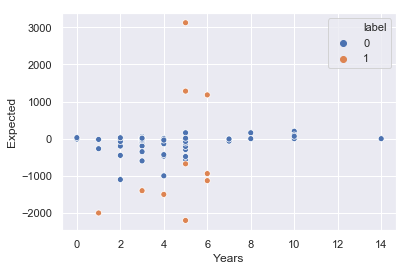

In [32]:
import seaborn as sns; sns.set()

color_theme = np.array(['darkgray', 'lightsalmon', 'powderblue'])
sns.scatterplot(x="Years", y="Expected", hue='label' , data=data)

In [ ]:
#color_theme = np.array(['darkgray', 'lightsalmon', 'powderblue'])

sns.scatterplot(x="Goal (USD millions)", y="Raised (USD millions)", data=data)

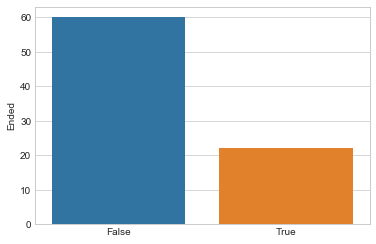

In [3]:
sns.set_style('whitegrid')
sns.barplot(df['Ended'].unique(), df['Ended'].value_counts())

In [4]:
#serach rows with string
#df[df['End Date'].str.contains("No end date")]
#Rename
#df = df.rename(index=str, columns={"Running": "Ended"})
# sum of unique values in a column

#Couting null
#dataset.isnull().sum()

#Searching nans
#nans = lambda df: df[df.isnull().any(axis=1)]
#nans(df)

#pivotting
#test = pd.melt(df2, id_vars=['College','Year Started','End Date','Top priorities','Ended','Years','Expected']).sort_values(['variable','value'])

df['End Date'].value_counts()

2020    21
2018    21
2022     9
2021     9
2019     9
2023     6
2017     6
2025     1
Name: End Date, dtype: int64

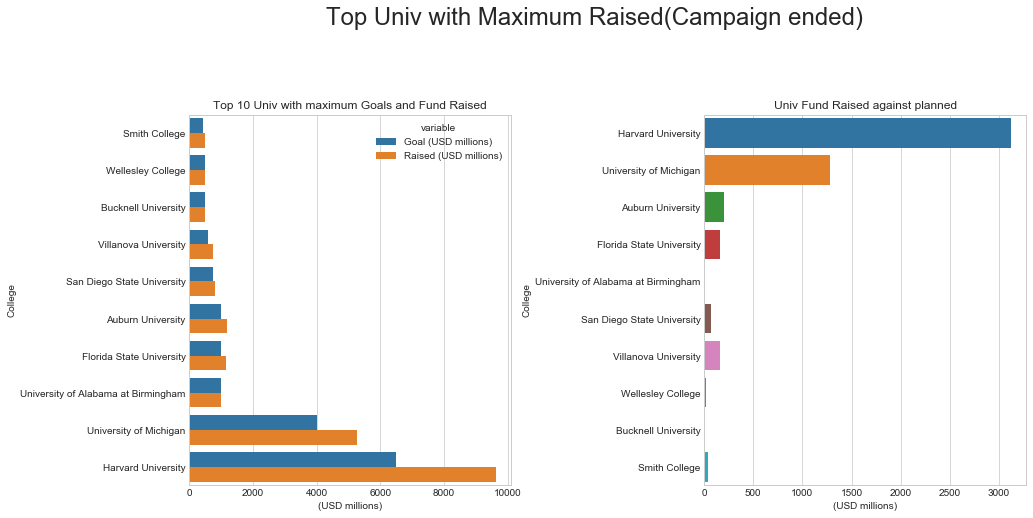

In [5]:
# Top 10 Universities max raised Campaign Ended
df8 = df.loc[df['Ended'] == True]
df8 = df8.sort_values(by=['Raised (USD millions)'], ascending=False).head(n=10)


index = np.arange(10)
bar_width = 0.25
opacity = 0.8
 
#plt.show()

plt.figure(figsize=(15,15))
plt.suptitle('Top Univ with Maximum Raised(Campaign ended)', fontsize=24)
plt.subplot(2,2,1)

sns.set_style('whitegrid')
test = pd.melt(df8, id_vars=['College','Year Started','End Date','Top priorities','Ended','Years','Expected']).sort_values(['variable','value'])
sns.barplot(x='value', y='College', hue='variable', data=test)
#plt.barh(index, df2['Goal (USD millions)'], bar_width, alpha=opacity, color='b', label='Goal')
#plt.barh(index + bar_width, df2['Raised (USD millions)'], bar_width, alpha=opacity, color='g', label='Raised')
 
plt.xlabel('(USD millions)')
plt.title('Top 10 Univ with maximum Goals and Fund Raised')
#plt.yticks(index, df2['College'])
#plt.xticks(index, np.arange(0.0, 120, 1.0))
#plt.legend(loc='best')


plt.subplot(2,2,2) 
sns.set_style('whitegrid')    
sns.barplot(df8['Expected'], df8['College'])
#plt.barh(index, df2['Expected'], bar_width, alpha=opacity, color='b', label='Raised')
#plt.barh(index + bar_width, df3['Raised (USD millions)'], bar_width, alpha=opacity, color='g', label='Raised')
 
plt.xlabel('(USD millions)')
plt.title('Univ Fund Raised against planned')
#plt.yticks(index, df2['College'])
#plt.xticks(index, np.arange(0.0, 120, 1.0))
#plt.legend(loc='best')
#plt.subplots_adjust(wspace = 0.8 )
plt.subplots_adjust(hspace=0.2, wspace = 0.6)

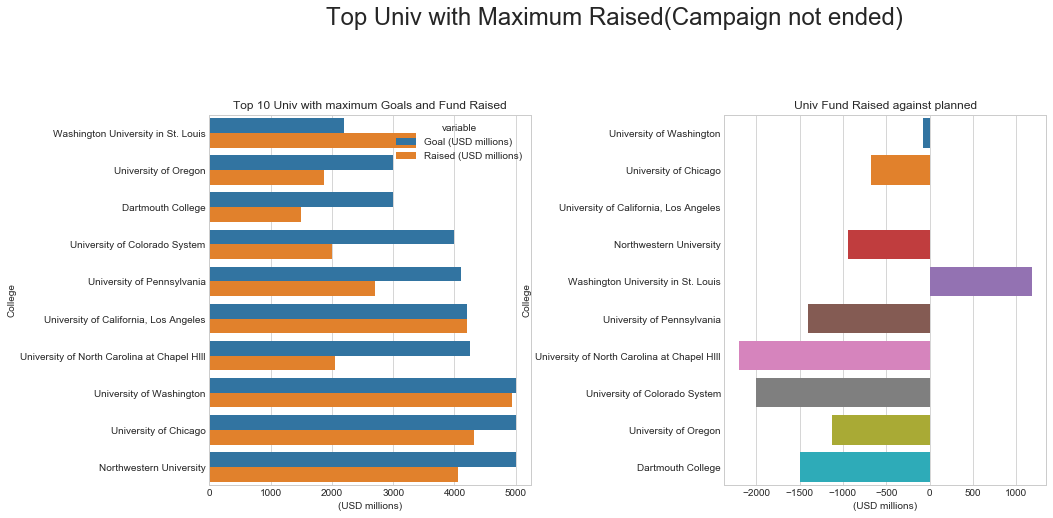

In [6]:
# Top 10 Universities max raised Campaign not Ended
df8 = df.loc[df['Ended'] == False]
df8 = df8.sort_values(by=['Raised (USD millions)'], ascending=False).head(n=10)


index = np.arange(10)
bar_width = 0.25
opacity = 0.8
 
#plt.show()

plt.figure(figsize=(15,15))
plt.suptitle('Top Univ with Maximum Raised(Campaign not ended)', fontsize=24)
plt.subplot(2,2,1)

sns.set_style('whitegrid')
test = pd.melt(df8, id_vars=['College','Year Started','End Date','Top priorities','Ended','Years','Expected']).sort_values(['variable','value'])
sns.barplot(x='value', y='College', hue='variable', data=test)
#plt.barh(index, df2['Goal (USD millions)'], bar_width, alpha=opacity, color='b', label='Goal')
#plt.barh(index + bar_width, df2['Raised (USD millions)'], bar_width, alpha=opacity, color='g', label='Raised')
 
plt.xlabel('(USD millions)')
plt.title('Top 10 Univ with maximum Goals and Fund Raised')
#plt.yticks(index, df2['College'])
#plt.xticks(index, np.arange(0.0, 120, 1.0))
#plt.legend(loc='best')


plt.subplot(2,2,2) 
sns.set_style('whitegrid')    
sns.barplot(df8['Expected'], df8['College'])
#plt.barh(index, df2['Expected'], bar_width, alpha=opacity, color='b', label='Raised')
#plt.barh(index + bar_width, df3['Raised (USD millions)'], bar_width, alpha=opacity, color='g', label='Raised')
 
plt.xlabel('(USD millions)')
plt.title('Univ Fund Raised against planned')
#plt.yticks(index, df2['College'])
#plt.xticks(index, np.arange(0.0, 120, 1.0))
#plt.legend(loc='best')
#plt.subplots_adjust(wspace = 0.8 )
plt.subplots_adjust(hspace=0.2, wspace = 0.6)

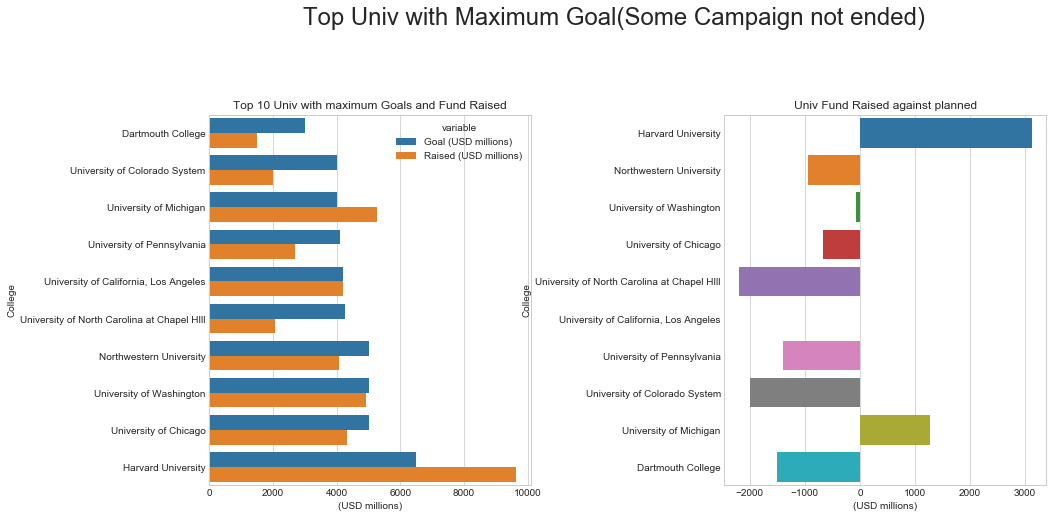

In [7]:
# Top 10 Universities exceeded goal including Campaign Not Ended
df2 = df.sort_values(by=['Goal (USD millions)'], ascending=False)
df2 = df2.head(n=10)
index = np.arange(10)
bar_width = 0.25
opacity = 0.8
 
#plt.show()

plt.figure(figsize=(15,15))
plt.suptitle('Top Univ with Maximum Goal(Some Campaign not ended)', fontsize=24)
plt.subplot(2,2,1)

sns.set_style('whitegrid')
test = pd.melt(df2, id_vars=['College','Year Started','End Date','Top priorities','Ended','Years','Expected']).sort_values(['variable','value'])
sns.barplot(x='value', y='College', hue='variable', data=test)
#plt.barh(index, df2['Goal (USD millions)'], bar_width, alpha=opacity, color='b', label='Goal')
#plt.barh(index + bar_width, df2['Raised (USD millions)'], bar_width, alpha=opacity, color='g', label='Raised')
 
plt.xlabel('(USD millions)')
plt.title('Top 10 Univ with maximum Goals and Fund Raised')
#plt.yticks(index, df2['College'])
#plt.xticks(index, np.arange(0.0, 120, 1.0))
#plt.legend(loc='best')


plt.subplot(2,2,2) 
sns.set_style('whitegrid')    
sns.barplot(df2['Expected'], df2['College'])
#plt.barh(index, df2['Expected'], bar_width, alpha=opacity, color='b', label='Raised')
#plt.barh(index + bar_width, df3['Raised (USD millions)'], bar_width, alpha=opacity, color='g', label='Raised')
 
plt.xlabel('(USD millions)')
plt.title('Univ Fund Raised against planned')
#plt.yticks(index, df2['College'])
#plt.xticks(index, np.arange(0.0, 120, 1.0))
#plt.legend(loc='best')
#plt.subplots_adjust(wspace = 0.8 )
plt.subplots_adjust(hspace=0.2, wspace = 0.6)

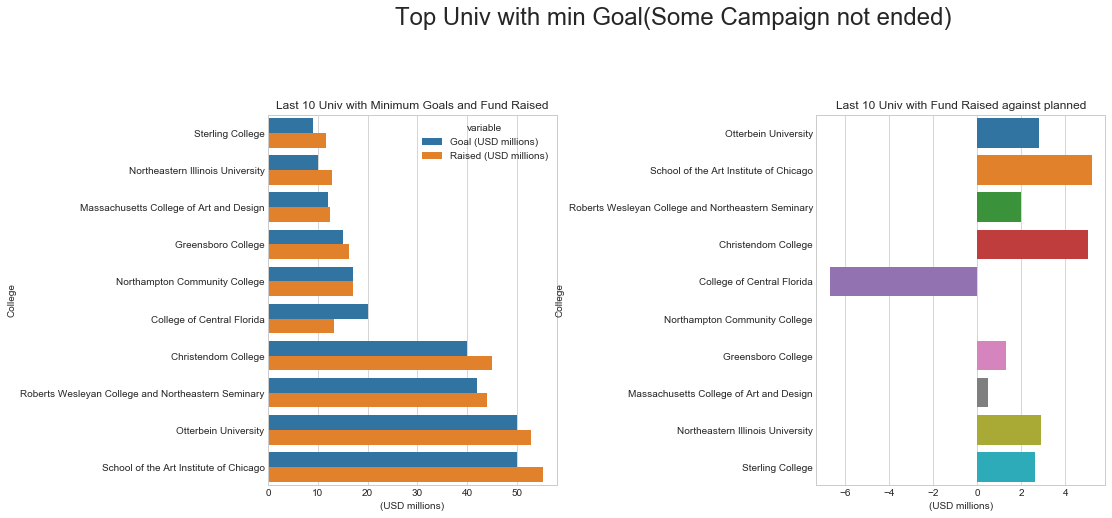

In [8]:
index = np.arange(10)
bar_width = 0.25
opacity = 0.8
 
# Top 10 Universities with minimum goal
df4 = df.sort_values(by=['Goal (USD millions)'], ascending=False).tail(n=10)

plt.figure(figsize=(15,15))
plt.suptitle('Top Univ with min Goal(Some Campaign not ended)', fontsize=24)
plt.subplot(2,2,1)

sns.set_style('whitegrid')
test = pd.melt(df4, id_vars=['College','Year Started','End Date','Top priorities','Ended','Years','Expected']).sort_values(['variable','value'])
sns.barplot(x='value', y='College', hue='variable', data=test)
#plt.barh(index, df4['Goal (USD millions)'], bar_width, alpha=opacity, color='b', label='Goal')
#plt.barh(index + bar_width, df4['Raised (USD millions)'], bar_width, alpha=opacity, color='g', label='Raised')
 
plt.xlabel('(USD millions)')
plt.title('Last 10 Univ with Minimum Goals and Fund Raised')
#plt.yticks(index, df4['College'])
#plt.xticks(index, np.arange(0.0, 120, 1.0))
#plt.legend(loc='best')

plt.subplot(2,2,2)

sns.barplot(df4['Expected'], df4['College'])
#plt.barh(index, df4['Expected'], bar_width, alpha=opacity, color='b', label='Raised')
#plt.barh(index + bar_width, df3['Raised (USD millions)'], bar_width, alpha=opacity, color='g', label='Raised')
 
plt.xlabel('(USD millions)')
plt.title('Last 10 Univ with Fund Raised against planned')
#plt.yticks(index, df4['College'])
#plt.xticks(index, np.arange(0.0, 120, 1.0))
#plt.legend(loc='best')
plt.subplots_adjust(hspace=0.2, wspace = 0.9)

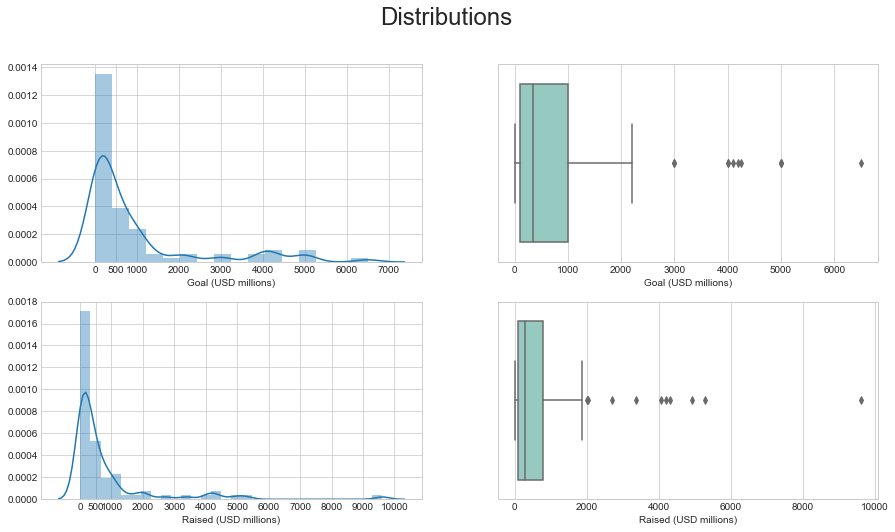

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
plt.suptitle('Distributions', fontsize=24)

plt.subplot(2,2,1)
plt.xticks([0, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
#plt.xlabel('Purchase amount', fontsize=18)

sns.distplot(df['Goal (USD millions)'])

plt.subplot(2,2,2)
sns.boxplot(x=df['Goal (USD millions)'],  palette="Set3")

plt.subplot(2,2,3)
plt.xticks([0, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12000])
sns.distplot(df['Raised (USD millions)'])
plt.subplot(2,2,4)
sns.boxplot(x=df['Raised (USD millions)'],  palette="Set3")

plt.subplots_adjust(hspace=0.2, wspace = 0.2 )

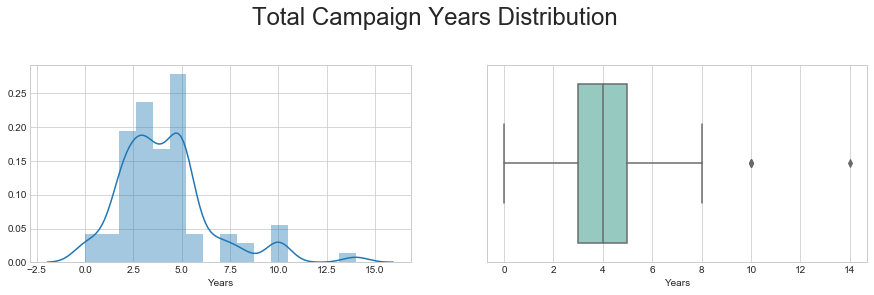

In [10]:
df6 = df.loc[df['Ended'] == True]
df6 = df6.sort_values(by=['Expected'], ascending=False)


plt.figure(figsize=(15,8))
plt.suptitle('Total Campaign Years Distribution', fontsize=24)


#plt.subplot(2,2,1)
#sns.distplot(df6.Years)

#plt.subplot(2,2,2)
#sns.boxplot(x=df6['Years'], palette="Set3")

plt.subplot(2,2,1)
sns.distplot(df.Years)

plt.subplot(2,2,2)
sns.boxplot(x=df['Years'], palette="Set3")
plt.subplots_adjust(hspace=0.2, wspace = 0.2 )

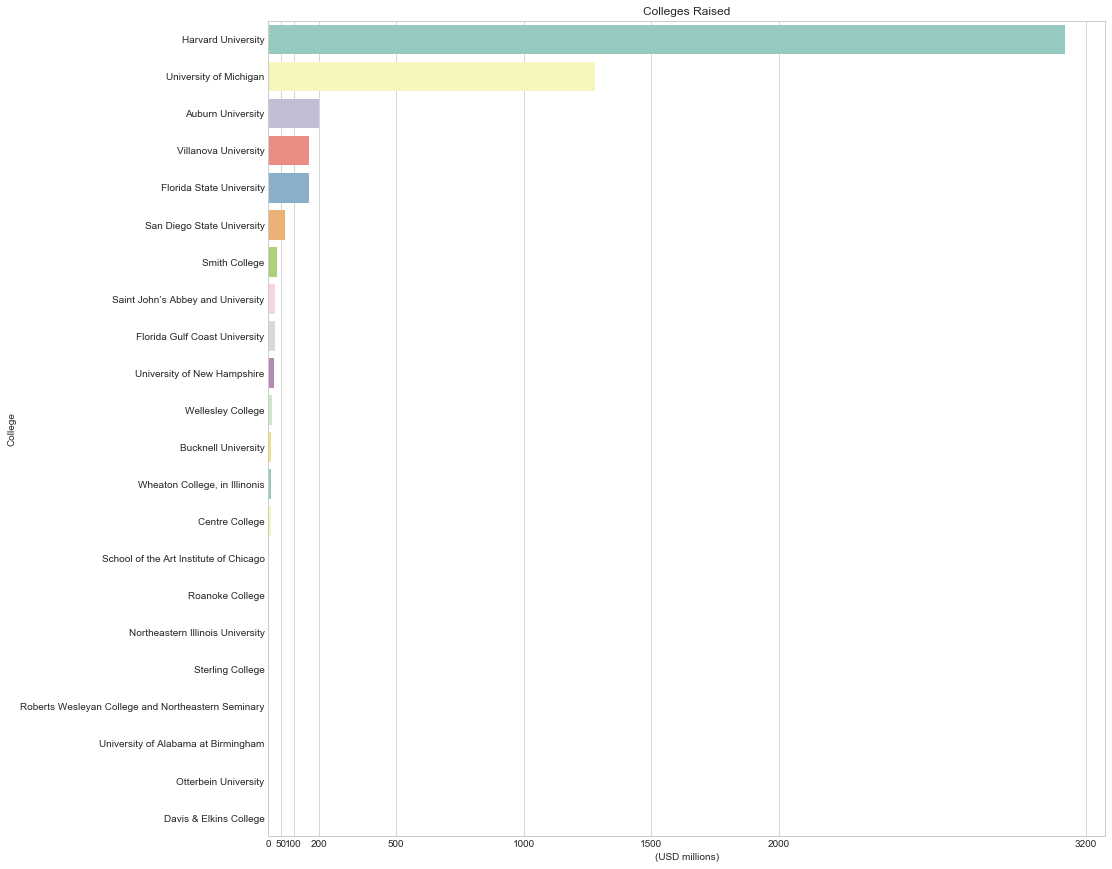

In [11]:
index = np.arange(22)
bar_width = 0.25
opacity = 0.8
plt.figure(figsize=(15,15))
sns.set_style('whitegrid')
sns.barplot(df6['Expected'], df6['College'], palette="Set3")
#plt.barh(index, df6['Expected'], bar_width, alpha=opacity, color='b', label='Raised')
#plt.barh(index + bar_width, df3['Raised (USD millions)'], bar_width, alpha=opacity, color='g', label='Raised')
 
plt.xlabel('(USD millions)')
plt.title('Colleges Raised')
plt.xticks([0, 50, 100, 200, 500, 1000, 1500, 2000, 3200])
#plt.yticks(index, df6['College'])
#plt.xticks(index, np.arange(0.0, 120, 1.0))
#plt.legend(loc='best')
plt.show()

In [12]:
from nltk.corpus import stopwords 
from textblob import TextBlob
import string 

stopwords = stopwords.words("english")

def _clean(txt):
    # lower case
    txt = txt.lower()

    # punctuation removal 
    txt = ''.join(x for x in txt if x not in string.punctuation)

    # stopwords and lemmatization
    clean_txt = ""
    for word in txt.split():
        if word in stopwords:
            continue 
        clean_txt += " "
        clean_txt += word 
    
    noise = ['students','my','title', 'would', 'every', 'will', 'many','also','donotremoveessaydivider']
    for ns in noise:
        clean_txt = clean_txt.replace(ns, "")

    return clean_txt


df['Top priorities'] = df['Top priorities'].apply(_clean)

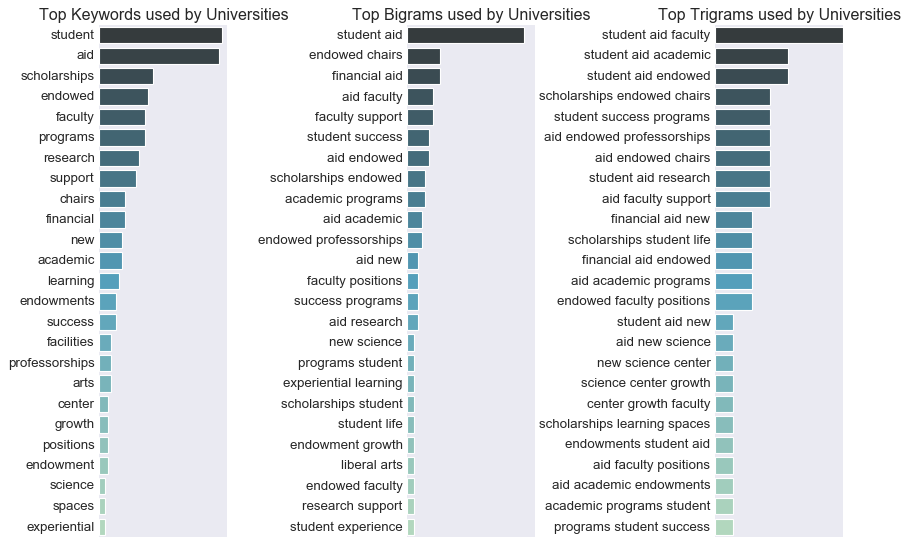

In [13]:
plt.style.use('classic')
### Bag of Words 
from collections import Counter
def generate_ngrams(txt, N):
    grams = [txt[i:i+N] for i in range(len(txt)-N+1)]
    grams = [" ".join(b) for b in grams]
    return grams 

df['unigrams'] = df['Top priorities'].apply(lambda x : generate_ngrams(x.split(), 1))
df['bigrams'] = df['Top priorities'].apply(lambda x : generate_ngrams(x.split(), 2))
df['trigrams'] = df['Top priorities'].apply(lambda x : generate_ngrams(x.split(), 3))

all_unigrams = []
for each in df['unigrams']:
    all_unigrams.extend(each)
t = Counter(all_unigrams).most_common(25)
x = [a[0] for a in t]
y = [a[1] for a in t]

all_bigrams = []
for each in df['bigrams']:
    all_bigrams.extend(each)
t1 = Counter(all_bigrams).most_common(25)
x1 = [a[0] for a in t1]
y1 = [a[1] for a in t1]


all_trigrams = []
for each in df['trigrams']:
    all_trigrams.extend(each)
t2 = Counter(all_trigrams).most_common(25)
x2 = [a[0] for a in t2]
y2 = [a[1] for a in t2]

sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, ncols=5, squeeze=True, figsize = (12,8));

bar = sns.barplot(y=x, x=y, ax=axes[0], palette='GnBu_d', edgecolor="white");
bar.set(xlabel='', xticks=[]);
axes[0].set_title("Top Keywords used by Universities");

fig.delaxes(axes[1]);

bar1 = sns.barplot(y=x1, x=y1, ax=axes[2], palette='GnBu_d', edgecolor="white");
bar1.set(xlabel='', xticks=[]);
axes[2].set_title("Top Bigrams used by Universities");

fig.delaxes(axes[3]);

bar1 = sns.barplot(y=x2, x=y2, ax=axes[4], palette='GnBu_d', edgecolor="white");
bar1.set(xlabel='', xticks=[]);
axes[4].set_title("Top Trigrams used by Universities");

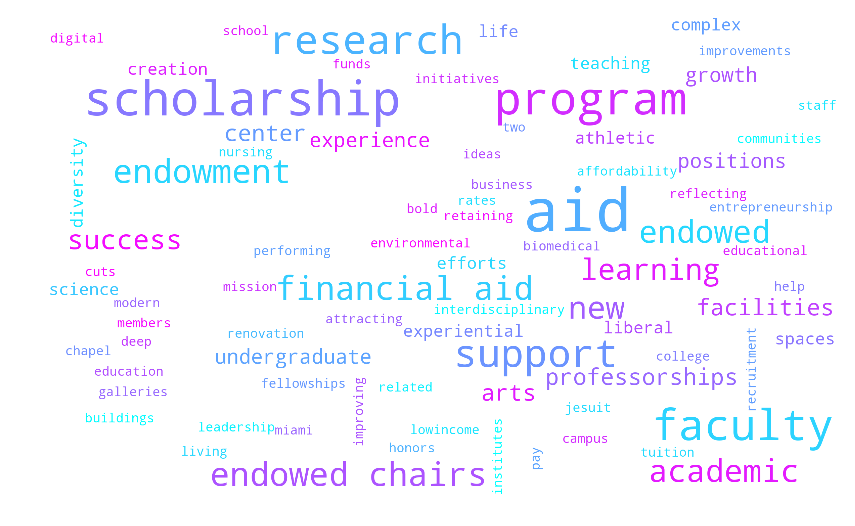

In [14]:
text = " ".join(df['Top priorities']).lower()
for w in ['need', 'student', 'classroom']: # remove some additional noise 
    text = text.replace(w, " ")

from PIL import Image
mask = np.array(Image.open('./degrees.png'))
wc = WordCloud(max_words=1200, stopwords=stopwords, colormap='cool', background_color='White', mask=mask).generate(text)
plt.figure(figsize=(13,13))
plt.imshow(wc)
plt.axis('off')
plt.title('');